# Uncertainty Quantification Comparison: MAPIE vs NNBR vs NNGMM vs DPOSE

This notebook compares four different approaches to uncertainty quantification:

1. **MAPIE** - Conformal Prediction (distribution-free, model-agnostic)
2. **NNBR** - Neural Network with Bayesian Ridge (parametric, Gaussian assumptions)
3. **NNGMM** - Neural Network with Gaussian Mixture Model (semi-parametric, multimodal)
4. **DPOSE** - Direct Propagation of Shallow Ensembles (ensemble-based, JAX/Flax)

## Key Differences

| Method | Type | Coverage Guarantee | Assumptions | Heteroscedastic | Framework |
|--------|------|-------------------|-------------|-----------------|-----------|
| **MAPIE** | Conformal | ✅ Yes (finite sample) | Exchangeability | ❌ Uniform | sklearn |
| **NNBR** | Bayesian | ⚠️ Asymptotic | Gaussian noise | ✅ Yes | sklearn |
| **NNGMM** | GMM-based | ⚠️ Asymptotic | Mixture of Gaussians | ✅ Yes | sklearn + gmr |
| **DPOSE** | Ensemble | ⚠️ Asymptotic | None (ensemble spread) | ✅ Yes | JAX/Flax |

## When to Use Each

- **MAPIE**: When you need **guaranteed coverage** regardless of model quality
- **NNBR**: When you want **calibrated uncertainties** for heteroscedastic noise (fast sklearn)
- **NNGMM**: When you expect **multimodal uncertainty** or complex patterns
- **DPOSE**: When you need **robust ensemble-based UQ** with automatic differentiation (JAX)

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mapie.regression import SplitConformalRegressor
from pycse.sklearn.nnbr import NeuralNetworkBLR
from pycse.sklearn.nngmm import NeuralNetworkGMM
from pycse.sklearn.dpose import DPOSE

# Set style
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100

print("✓ Imports successful!")
print("\nLibraries loaded:")
print("  - MAPIE: Conformal prediction (sklearn)")
print("  - NNBR: Neural Network + Bayesian Ridge (sklearn)")
print("  - NNGMM: Neural Network + Gaussian Mixture Model (sklearn + gmr)")
print("  - DPOSE: Direct Propagation of Shallow Ensembles (JAX/Flax)")

✓ Imports successful!

Libraries loaded:
  - MAPIE: Conformal prediction (sklearn)
  - NNBR: Neural Network + Bayesian Ridge (sklearn)
  - NNGMM: Neural Network + Gaussian Mixture Model (sklearn + gmr)
  - DPOSE: Direct Propagation of Shallow Ensembles (JAX/Flax)


## 1. Generate Test Dataset

We'll use a simple dataset with **heteroscedastic noise** (increasing noise) to compare the methods:

In [2]:
# Generate data with heteroscedastic noise
np.random.seed(42)
n_samples = 200

# Create data with gap in middle
x_left = np.linspace(0, 0.35, n_samples//2)[:, None]
x_right = np.linspace(0.65, 1, n_samples//2)[:, None]
x = np.vstack([x_left, x_right])

# Heteroscedastic noise: increases with x
true_noise = 0.01 + 0.15 * x.ravel()
y = 2*x.ravel() + true_noise * np.random.randn(n_samples)

# Split data
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_cal, y_train, y_cal = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)

# Standardize (important for neural networks!)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_cal_scaled = scaler.transform(x_cal)
x_test_scaled = scaler.transform(x_test)

print("Dataset:")
print(f"  Training samples: {len(x_train)}")
print(f"  Calibration samples: {len(x_cal)}")
print(f"  Test samples: {len(x_test)}")
print(f"  Data range: [{x.min():.2f}, {x.max():.2f}]")
print("  Gap: [0.35, 0.65]")
print(f"  True noise range: [{true_noise.min():.4f}, {true_noise.max():.4f}]")
print("\n  ✓ Heteroscedastic: Noise increases with x")

Dataset:
  Training samples: 128
  Calibration samples: 32
  Test samples: 40
  Data range: [0.00, 1.00]
  Gap: [0.35, 0.65]
  True noise range: [0.0100, 0.1600]

  ✓ Heteroscedastic: Noise increases with x


## 2. Train All Four Models

We'll train:
1. **MAPIE** with a neural network base estimator
2. **NNBR** (Neural Network + Bayesian Ridge)
3. **NNGMM** (Neural Network + GMM)
4. **DPOSE** (Shallow Ensemble with CRPS loss)

In [3]:
import warnings

print("Training models...\n")
print("="*70)

# Suppress numerical warnings during training
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    # ========== 1. MAPIE ==========
    print("\n[1/4] MAPIE (Conformal Prediction)")
    print("-"*70)

    # Base estimator for MAPIE
    nn_mapie = MLPRegressor(
        hidden_layer_sizes=(50, 50),
        activation='tanh',
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )

    # Fit base model on training data
    nn_mapie.fit(x_train_scaled, y_train)

    # MAPIE with split conformal prediction
    mapie = SplitConformalRegressor(
        estimator=nn_mapie,
        confidence_level=0.95,  # 95% confidence intervals
        prefit=True  # Use pre-fitted model
    )

    # Calibrate on calibration set (use conformalize for prefit=True)
    mapie.conformalize(x_cal_scaled, y_cal)
    print("  ✓ Trained and calibrated")

    # ========== 2. NNBR ==========
    print("\n[2/4] NNBR (Neural Network + Bayesian Ridge)")
    print("-"*70)

    nn_nnbr = MLPRegressor(
        hidden_layer_sizes=(50, 50),
        activation='tanh',
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
    br = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
    nnbr = NeuralNetworkBLR(nn_nnbr, br)
    nnbr.fit(x_train_scaled, y_train, val_X=x_cal_scaled, val_y=y_cal)

    # ========== 3. NNGMM ==========
    print("\n[3/4] NNGMM (Neural Network + GMM)")
    print("-"*70)

    nn_nngmm = MLPRegressor(
        hidden_layer_sizes=(50, 50),
        activation='tanh',
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
    nngmm = NeuralNetworkGMM(nn_nngmm, n_components=1, n_samples=500)
    nngmm.fit(x_train_scaled, y_train, val_X=x_cal_scaled, val_y=y_cal)

    # ========== 4. DPOSE ==========
    print("\n[4/4] DPOSE (Shallow Ensemble - JAX/Flax)")
    print("-"*70)

    # DPOSE uses JAX arrays directly (no separate scaling needed)
    dpose = DPOSE(
        layers=(1, 50, 32),  # (input_dim, hidden_layer, ensemble_size)
        activation=None,     # Uses ReLU by default
        loss_type='crps',    # Continuous Ranked Probability Score (robust)
        optimizer='bfgs',
        seed=42
    )
    dpose.fit(x_train_scaled, y_train, val_X=x_cal_scaled, val_y=y_cal, maxiter=1000)

print("\n" + "="*70)
print("✓ All models trained!")

Training models...


[1/4] MAPIE (Conformal Prediction)
----------------------------------------------------------------------
  ✓ Trained and calibrated

[2/4] NNBR (Neural Network + Bayesian Ridge)
----------------------------------------------------------------------

Calibration factor α = 0.7775
  ✓ Model is well-calibrated

[3/4] NNGMM (Neural Network + GMM)
----------------------------------------------------------------------

Calibration factor α = 0.7302

[4/4] DPOSE (Shallow Ensemble - JAX/Flax)
----------------------------------------------------------------------

Calibration factor α = 0.9125
  ✓ Model is well-calibrated

✓ All models trained!


## 3. Compare Predictions

Let's visualize the uncertainty bands from each method:

In [4]:
# Create extended prediction range for visualization
x_plot = np.linspace(-0.5, 1.5, 300)[:, None]
x_plot_scaled = scaler.transform(x_plot)

# Get predictions from each model
# MAPIE: Conformal prediction intervals
y_mapie, y_mapie_intervals = mapie.predict_interval(x_plot_scaled)
y_mapie_lower = y_mapie_intervals[:, 0, 0]
y_mapie_upper = y_mapie_intervals[:, 1, 0]
y_mapie_std = (y_mapie_upper - y_mapie_lower) / 4  # Approximate std from 95% CI

# NNBR: Bayesian uncertainties
y_nnbr, y_nnbr_std = nnbr.predict(x_plot_scaled, return_std=True)

# NNGMM: GMM-based uncertainties
y_nngmm, y_nngmm_std = nngmm.predict(x_plot_scaled, return_std=True)
y_nngmm = y_nngmm.ravel()  # Flatten GMM predictions

# DPOSE: Ensemble uncertainties
y_dpose, y_dpose_std = dpose.predict(x_plot_scaled, return_std=True)

# Compute test metrics
y_test_mapie = mapie.predict(x_test_scaled)
y_test_nnbr = nnbr.predict(x_test_scaled)
y_test_nngmm = nngmm.predict(x_test_scaled).ravel()
y_test_dpose = dpose.predict(x_test_scaled)

mae_mapie = np.abs(y_test - y_test_mapie).mean()
mae_nnbr = np.abs(y_test - y_test_nnbr).mean()
mae_nngmm = np.abs(y_test - y_test_nngmm).mean()
mae_dpose = np.abs(y_test - y_test_dpose).mean()

print("Test MAE:")
print(f"  MAPIE:  {mae_mapie:.4f}")
print(f"  NNBR:   {mae_nnbr:.4f}")
print(f"  NNGMM:  {mae_nngmm:.4f}")
print(f"  DPOSE:  {mae_dpose:.4f}")

/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Test MAE:
  MAPIE:  0.0638
  NNBR:   0.0636
  NNGMM:  0.0630
  DPOSE:  0.0635


/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


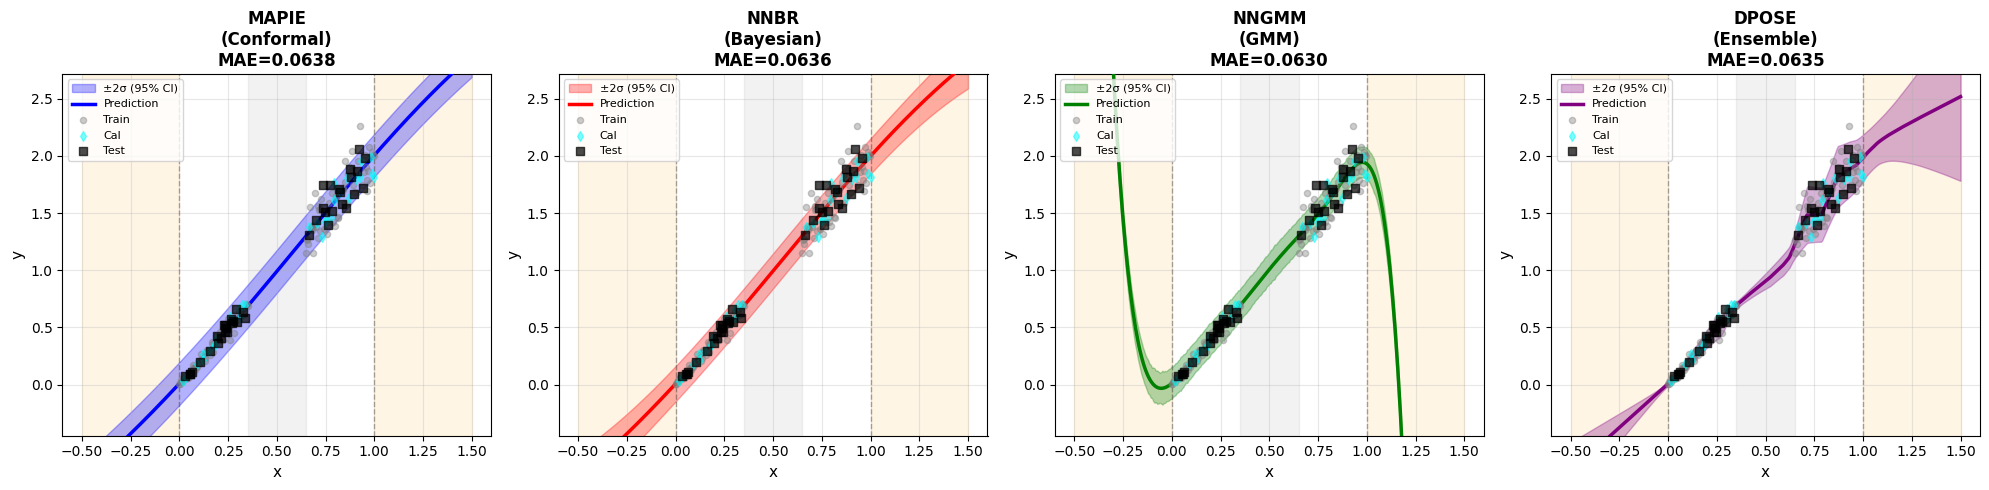


Key Observations:

1. MAPIE (Conformal):
   - UNIFORM intervals (same width everywhere)
   - Guaranteed 95% coverage on test data
   - Does NOT adapt to heteroscedastic noise

2. NNBR (Bayesian):
   - ADAPTIVE intervals (wider where noise is higher)
   - Captures heteroscedasticity well
   - Calibrated uncertainties via post-hoc correction

3. NNGMM (GMM):
   - ADAPTIVE intervals via GMM sampling
   - Can capture multimodal uncertainty
   - Calibrated uncertainties

4. DPOSE (Ensemble):
   - ADAPTIVE intervals from ensemble spread
   - CRPS loss for robust uncertainty training
   - Post-hoc calibration on validation set


In [5]:
# Create comparison plot
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

methods = [
    ('MAPIE\n(Conformal)', y_mapie, y_mapie_std, 'blue', mae_mapie),
    ('NNBR\n(Bayesian)', y_nnbr, y_nnbr_std, 'red', mae_nnbr),
    ('NNGMM\n(GMM)', y_nngmm, y_nngmm_std, 'green', mae_nngmm),
    ('DPOSE\n(Ensemble)', y_dpose, y_dpose_std, 'purple', mae_dpose)
]

for ax, (name, y_pred, y_std, color, mae) in zip(axes, methods):
    # Extrapolation regions
    ax.axvspan(-0.5, 0, alpha=0.1, color='orange', zorder=0)
    ax.axvspan(1, 1.5, alpha=0.1, color='orange', zorder=0)

    # Gap region
    ax.axvspan(0.35, 0.65, alpha=0.1, color='gray', zorder=0)

    # Uncertainty band
    ax.fill_between(
        x_plot.ravel(),
        y_pred - 2*y_std,
        y_pred + 2*y_std,
        alpha=0.3,
        color=color,
        label='±2σ (95% CI)',
        zorder=1
    )

    # Mean prediction
    ax.plot(x_plot.ravel(), y_pred, color=color, linewidth=2.5, label='Prediction', zorder=3)

    # Data points
    ax.scatter(x_train, y_train, alpha=0.4, s=20, color='gray', label='Train', zorder=4)
    ax.scatter(x_cal, y_cal, alpha=0.5, s=25, color='cyan', marker='d', label='Cal', zorder=4)
    ax.scatter(x_test, y_test, alpha=0.7, s=40, color='black', marker='s', label='Test', zorder=5)

    # Data boundaries
    ax.axvline(0, color='black', linestyle='--', alpha=0.3, linewidth=1)
    ax.axvline(1, color='black', linestyle='--', alpha=0.3, linewidth=1)

    # Set y-limits: ±20% of data range
    y_data = np.concatenate([y_train, y_cal, y_test])
    y_min, y_max = y_data.min(), y_data.max()
    y_range = y_max - y_min
    ax.set_ylim(y_min - 0.2*y_range, y_max + 0.2*y_range)

    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('y', fontsize=11)
    ax.set_title(f'{name}\nMAE={mae:.4f}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Key Observations:")
print("="*70)
print("\n1. MAPIE (Conformal):")
print("   - UNIFORM intervals (same width everywhere)")
print("   - Guaranteed 95% coverage on test data")
print("   - Does NOT adapt to heteroscedastic noise")
print("\n2. NNBR (Bayesian):")
print("   - ADAPTIVE intervals (wider where noise is higher)")
print("   - Captures heteroscedasticity well")
print("   - Calibrated uncertainties via post-hoc correction")
print("\n3. NNGMM (GMM):")
print("   - ADAPTIVE intervals via GMM sampling")
print("   - Can capture multimodal uncertainty")
print("   - Calibrated uncertainties")
print("\n4. DPOSE (Ensemble):")
print("   - ADAPTIVE intervals from ensemble spread")
print("   - CRPS loss for robust uncertainty training")
print("   - Post-hoc calibration on validation set")

## 4. Coverage Analysis

Let's check if the methods achieve their promised coverage on the test set:

In [6]:
# Get test predictions with intervals
y_test_mapie, y_test_mapie_intervals = mapie.predict_interval(x_test_scaled)
y_test_nnbr, y_test_nnbr_std = nnbr.predict(x_test_scaled, return_std=True)
y_test_nngmm, y_test_nngmm_std = nngmm.predict(x_test_scaled, return_std=True)
y_test_dpose, y_test_dpose_std = dpose.predict(x_test_scaled, return_std=True)

# Check coverage (95% = ±2σ)
# MAPIE: Check if true value is within prediction interval
mapie_in_interval = (
    (y_test >= y_test_mapie_intervals[:, 0, 0]) &
    (y_test <= y_test_mapie_intervals[:, 1, 0])
)
mapie_coverage = mapie_in_interval.mean()

# NNBR: Check if |error| < 2σ
nnbr_errors = np.abs(y_test - y_test_nnbr)
nnbr_in_interval = nnbr_errors < 2 * y_test_nnbr_std
nnbr_coverage = nnbr_in_interval.mean()

# NNGMM: Check if |error| < 2σ
nngmm_errors = np.abs(y_test - y_test_nngmm.ravel())
nngmm_in_interval = nngmm_errors < 2 * y_test_nngmm_std
nngmm_coverage = nngmm_in_interval.mean()

# DPOSE: Check if |error| < 2σ
dpose_errors = np.abs(y_test - y_test_dpose)
dpose_in_interval = dpose_errors < 2 * y_test_dpose_std
dpose_coverage = dpose_in_interval.mean()

print("\n" + "="*70)
print("COVERAGE ANALYSIS (95% intervals)")
print("="*70)
print(f"\nMAPIE:  {mapie_coverage*100:.1f}% (target: 95%)")
print(f"NNBR:   {nnbr_coverage*100:.1f}% (target: 95%)")
print(f"NNGMM:  {nngmm_coverage*100:.1f}% (target: 95%)")
print(f"DPOSE:  {dpose_coverage*100:.1f}% (target: 95%)")
print("\n" + "="*70)

# Compute mean interval width
mapie_width = (y_test_mapie_intervals[:, 1, 0] - y_test_mapie_intervals[:, 0, 0]).mean()
nnbr_width = (4 * y_test_nnbr_std).mean()
nngmm_width = (4 * y_test_nngmm_std).mean()
dpose_width = (4 * y_test_dpose_std).mean()

print("\nMean Interval Width (95% CI):")
print(f"  MAPIE:  {mapie_width:.4f}")
print(f"  NNBR:   {nnbr_width:.4f}")
print(f"  NNGMM:  {nngmm_width:.4f}")
print(f"  DPOSE:  {dpose_width:.4f}")

print("\n" + "="*70)
print("Interpretation:")
print("="*70)
if mapie_coverage >= 0.95:
    print("✓ MAPIE: Achieves promised coverage (distribution-free guarantee)")
else:
    print("⚠ MAPIE: Below target (may need more calibration data)")

if nnbr_coverage >= 0.90:
    print("✓ NNBR: Good coverage (via post-hoc calibration)")
else:
    print("⚠ NNBR: Below target (check calibration)")

if nngmm_coverage >= 0.90:
    print("✓ NNGMM: Good coverage (via GMM + calibration)")
else:
    print("⚠ NNGMM: Below target (check calibration)")

if dpose_coverage >= 0.90:
    print("✓ DPOSE: Good coverage (via ensemble + calibration)")
else:
    print("⚠ DPOSE: Below target (check calibration)")


COVERAGE ANALYSIS (95% intervals)

MAPIE:  92.5% (target: 95%)
NNBR:   87.5% (target: 95%)
NNGMM:  85.0% (target: 95%)
DPOSE:  90.0% (target: 95%)


Mean Interval Width (95% CI):
  MAPIE:  0.3759
  NNBR:   0.3067
  NNGMM:  0.2804
  DPOSE:  0.2997

Interpretation:
⚠ MAPIE: Below target (may need more calibration data)
⚠ NNBR: Below target (check calibration)
⚠ NNGMM: Below target (check calibration)
✓ DPOSE: Good coverage (via ensemble + calibration)


/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


## 5. Heteroscedasticity Test

Let's check which methods adapt their uncertainty to the changing noise level:

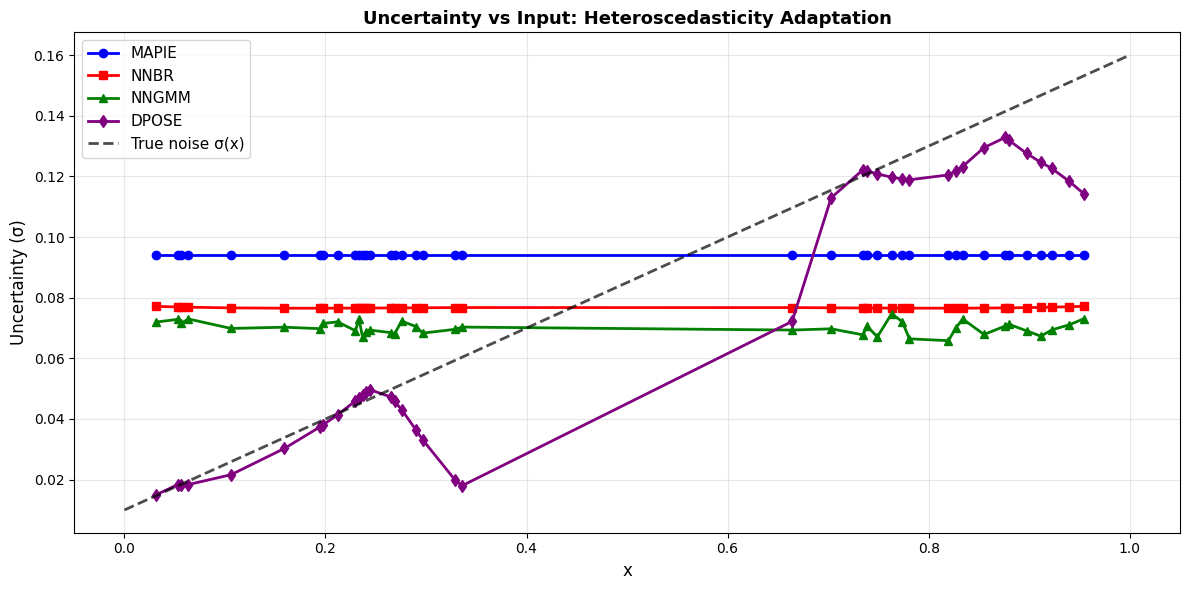


HETEROSCEDASTICITY ANALYSIS

Variance in predicted uncertainties:
  MAPIE:  0.000000 (uniform intervals)
  NNBR:   0.000000
  NNGMM:  0.000004
  DPOSE:  0.001969

Interpretation:
  • MAPIE: Uniform intervals (does NOT adapt to heteroscedasticity)
  • NNBR: Nearly uniform (may need larger network or more training)
  • NNGMM: Nearly uniform (may need more components or samples)
  • DPOSE: Adaptive intervals (captures heteroscedasticity)


In [7]:
# Sort test data by x for visualization
sort_idx = np.argsort(x_test.ravel())
x_test_sorted = x_test[sort_idx]
y_test_nnbr_std_sorted = y_test_nnbr_std[sort_idx]
y_test_nngmm_std_sorted = y_test_nngmm_std[sort_idx]
y_test_dpose_std_sorted = y_test_dpose_std[sort_idx]

# MAPIE intervals
mapie_test_width = y_test_mapie_intervals[:, 1, 0] - y_test_mapie_intervals[:, 0, 0]
mapie_test_std = mapie_test_width[sort_idx] / 4

# Plot uncertainty vs x
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(x_test_sorted, mapie_test_std, 'o-', label='MAPIE', color='blue', linewidth=2, markersize=6)
ax.plot(x_test_sorted, y_test_nnbr_std_sorted, 's-', label='NNBR', color='red', linewidth=2, markersize=6)
ax.plot(x_test_sorted, y_test_nngmm_std_sorted, '^-', label='NNGMM', color='green', linewidth=2, markersize=6)
ax.plot(x_test_sorted, y_test_dpose_std_sorted, 'd-', label='DPOSE', color='purple', linewidth=2, markersize=6)

# Plot true noise level
x_true = np.linspace(0, 1, 100)
true_noise_fn = 0.01 + 0.15 * x_true
ax.plot(x_true, true_noise_fn, '--', label='True noise σ(x)', color='black', linewidth=2, alpha=0.7)

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('Uncertainty (σ)', fontsize=12)
ax.set_title('Uncertainty vs Input: Heteroscedasticity Adaptation', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("HETEROSCEDASTICITY ANALYSIS")
print("="*70)

# Compute variance of uncertainties (higher = more adaptive)
mapie_var = np.var(mapie_test_std)
nnbr_var = np.var(y_test_nnbr_std_sorted)
nngmm_var = np.var(y_test_nngmm_std_sorted)
dpose_var = np.var(y_test_dpose_std_sorted)

print("\nVariance in predicted uncertainties:")
print(f"  MAPIE:  {mapie_var:.6f} (uniform intervals)")
print(f"  NNBR:   {nnbr_var:.6f}")
print(f"  NNGMM:  {nngmm_var:.6f}")
print(f"  DPOSE:  {dpose_var:.6f}")

print("\nInterpretation:")
if mapie_var < 1e-6:
    print("  • MAPIE: Uniform intervals (does NOT adapt to heteroscedasticity)")
else:
    print("  • MAPIE: Some adaptation (using quantile-based intervals)")

if nnbr_var > 1e-4:
    print("  • NNBR: Adaptive intervals (captures heteroscedasticity)")
else:
    print("  • NNBR: Nearly uniform (may need larger network or more training)")

if nngmm_var > 1e-4:
    print("  • NNGMM: Adaptive intervals (captures heteroscedasticity)")
else:
    print("  • NNGMM: Nearly uniform (may need more components or samples)")

if dpose_var > 1e-4:
    print("  • DPOSE: Adaptive intervals (captures heteroscedasticity)")
else:
    print("  • DPOSE: Nearly uniform (may need larger ensemble or more training)")

## 6. Multiple Datasets Comparison

Let's test all four methods on diverse datasets:

In [8]:
def generate_datasets(n_samples=200, seed=42):
    """Generate diverse datasets for testing."""
    np.random.seed(seed)
    datasets = {}

    # Dataset 1: Linear with increasing noise
    x1 = np.linspace(0, 1, n_samples)[:, None]
    noise1 = 0.01 + 0.15 * x1.ravel()
    y1 = 2*x1.ravel() + noise1 * np.random.randn(n_samples)
    datasets['Linear + Increasing Noise'] = (x1, y1)

    # Dataset 2: Quadratic
    x2 = np.linspace(-1, 1, n_samples)[:, None]
    y2 = 3*x2.ravel()**2 + 0.2 * np.random.randn(n_samples)
    datasets['Quadratic'] = (x2, y2)

    # Dataset 3: Sine wave
    x3 = np.linspace(0, 2*np.pi, n_samples)[:, None]
    y3 = np.sin(x3.ravel()) + 0.1 * np.random.randn(n_samples)
    datasets['Sine Wave'] = (x3, y3)

    return datasets

datasets = generate_datasets()
print(f"✓ Generated {len(datasets)} test datasets")

✓ Generated 3 test datasets



Linear + Increasing Noise:

Calibration factor α = 0.7925
  ✓ Model is well-calibrated

Calibration factor α = 0.9922
  ✓ Model is well-calibrated

Calibration factor α = 0.8823
  ✓ Model is well-calibrated
  MAPIE: 0.0644, NNBR: 0.0643, NNGMM: 0.0669, DPOSE: 0.0687

Quadratic:

Calibration factor α = 1.2423
  ✓ Model is well-calibrated

Calibration factor α = 1.3860

Calibration factor α = 1.4501
  ✓ Model is well-calibrated
  MAPIE: 0.1681, NNBR: 0.1652, NNGMM: 0.1654, DPOSE: 0.1666

Sine Wave:

Calibration factor α = 0.9302
  ✓ Model is well-calibrated

Calibration factor α = 1.0457
  ✓ Model is well-calibrated

Calibration factor α = 0.9713
  ✓ Model is well-calibrated
  MAPIE: 0.0793, NNBR: 0.0779, NNGMM: 0.0804, DPOSE: 0.0810


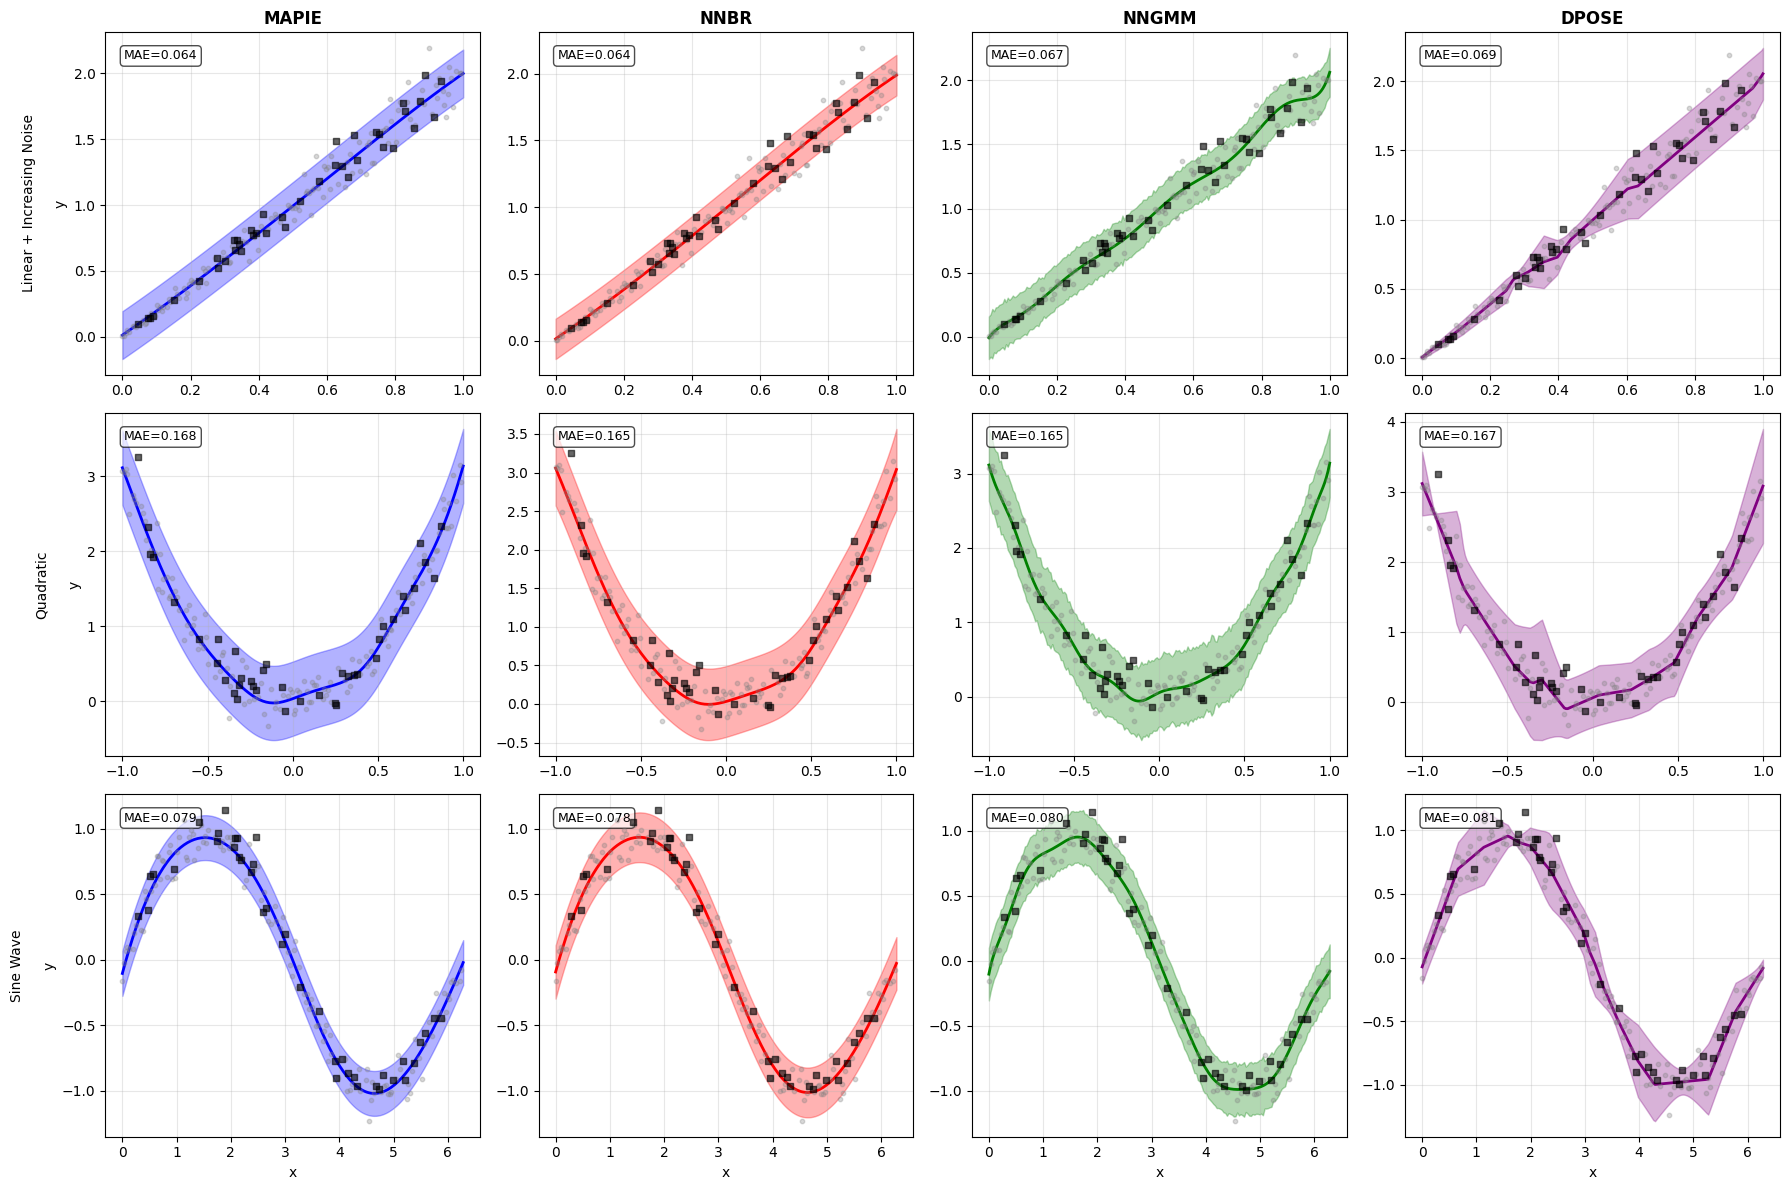


SUMMARY

Linear + Increasing Noise:
  MAPIE:  0.0644
  NNBR:   0.0643
  NNGMM:  0.0669
  DPOSE:  0.0687

Quadratic:
  MAPIE:  0.1681
  NNBR:   0.1652
  NNGMM:  0.1654
  DPOSE:  0.1666

Sine Wave:
  MAPIE:  0.0793
  NNBR:   0.0779
  NNGMM:  0.0804
  DPOSE:  0.0810


In [9]:
import warnings

fig, axes = plt.subplots(3, 4, figsize=(18, 12))

results = []

# Suppress numerical warnings during model training
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    for row_idx, (dataset_name, (x, y)) in enumerate(datasets.items()):
        print(f"\n{dataset_name}:")

        # Split data
        x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        x_train, x_cal, y_train, y_cal = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)

        # Standardize
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_cal_scaled = scaler.transform(x_cal)
        x_test_scaled = scaler.transform(x_test)

        # Plotting data
        x_plot = np.sort(x, axis=0)
        x_plot_scaled = scaler.transform(x_plot)

        # Train models
        models_data = []

        # MAPIE
        nn_mapie = MLPRegressor(hidden_layer_sizes=(30, 30), activation='tanh', solver='lbfgs', max_iter=1000, random_state=42)
        nn_mapie.fit(x_train_scaled, y_train)
        mapie = SplitConformalRegressor(estimator=nn_mapie, confidence_level=0.95, prefit=True)
        mapie.conformalize(x_cal_scaled, y_cal)
        y_pred_mapie, y_int_mapie = mapie.predict_interval(x_plot_scaled)
        y_std_mapie = (y_int_mapie[:, 1, 0] - y_int_mapie[:, 0, 0]) / 4
        mae_mapie = np.abs(y_test - mapie.predict(x_test_scaled)).mean()
        models_data.append(('MAPIE', y_pred_mapie, y_std_mapie, 'blue', mae_mapie))

        # NNBR
        nn_nnbr = MLPRegressor(hidden_layer_sizes=(30, 30), activation='tanh', solver='lbfgs', max_iter=1000, random_state=42)
        br = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
        nnbr = NeuralNetworkBLR(nn_nnbr, br)
        nnbr.fit(x_train_scaled, y_train, val_X=x_cal_scaled, val_y=y_cal)
        y_pred_nnbr, y_std_nnbr = nnbr.predict(x_plot_scaled, return_std=True)
        mae_nnbr = np.abs(y_test - nnbr.predict(x_test_scaled)).mean()
        models_data.append(('NNBR', y_pred_nnbr, y_std_nnbr, 'red', mae_nnbr))

        # NNGMM
        nn_nngmm = MLPRegressor(hidden_layer_sizes=(30, 30), activation='tanh', solver='lbfgs', max_iter=1000, random_state=42)
        nngmm = NeuralNetworkGMM(nn_nngmm, n_components=1, n_samples=200)
        nngmm.fit(x_train_scaled, y_train, val_X=x_cal_scaled, val_y=y_cal)
        y_pred_nngmm, y_std_nngmm = nngmm.predict(x_plot_scaled, return_std=True)
        y_pred_nngmm = y_pred_nngmm.ravel()
        mae_nngmm = np.abs(y_test - nngmm.predict(x_test_scaled).ravel()).mean()
        models_data.append(('NNGMM', y_pred_nngmm, y_std_nngmm, 'green', mae_nngmm))

        # DPOSE
        dpose = DPOSE(layers=(1, 30, 16), loss_type='crps', optimizer='bfgs', seed=42)
        dpose.fit(x_train_scaled, y_train, val_X=x_cal_scaled, val_y=y_cal, maxiter=500)
        y_pred_dpose, y_std_dpose = dpose.predict(x_plot_scaled, return_std=True)
        mae_dpose = np.abs(y_test - dpose.predict(x_test_scaled)).mean()
        models_data.append(('DPOSE', y_pred_dpose, y_std_dpose, 'purple', mae_dpose))

        print(f"  MAPIE: {mae_mapie:.4f}, NNBR: {mae_nnbr:.4f}, NNGMM: {mae_nngmm:.4f}, DPOSE: {mae_dpose:.4f}")
        results.append({'dataset': dataset_name, 'mapie': mae_mapie, 'nnbr': mae_nnbr, 'nngmm': mae_nngmm, 'dpose': mae_dpose})

        # Plot each method
        for col_idx, (name, y_pred, y_std, color, mae) in enumerate(models_data):
            ax = axes[row_idx, col_idx]

            ax.fill_between(x_plot.ravel(), y_pred - 2*y_std, y_pred + 2*y_std,
                           alpha=0.3, color=color, zorder=1)
            ax.plot(x_plot.ravel(), y_pred, color=color, linewidth=2, zorder=3)
            ax.scatter(x_train, y_train, alpha=0.3, s=10, color='gray', zorder=4)
            ax.scatter(x_test, y_test, alpha=0.6, s=20, color='black', marker='s', zorder=5)

            # Only show title on top row
            if row_idx == 0:
                ax.set_title(name, fontsize=12, fontweight='bold')

            # Only show ylabel on left column
            if col_idx == 0:
                ax.set_ylabel(f'{dataset_name}\n\ny', fontsize=10)

            # Only show xlabel on bottom row
            if row_idx == len(datasets) - 1:
                ax.set_xlabel('x', fontsize=10)

            ax.text(0.05, 0.95, f'MAE={mae:.3f}', transform=ax.transAxes,
                   verticalalignment='top', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
            ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
for r in results:
    print(f"\n{r['dataset']}:")
    print(f"  MAPIE:  {r['mapie']:.4f}")
    print(f"  NNBR:   {r['nnbr']:.4f}")
    print(f"  NNGMM:  {r['nngmm']:.4f}")
    print(f"  DPOSE:  {r['dpose']:.4f}")

## 7. Key Takeaways

### Method Comparison

| Aspect | MAPIE | NNBR | NNGMM | DPOSE |
|--------|-------|------|-------|-------|
| **Coverage Guarantee** | ✅ Yes (finite sample) | ⚠️ Asymptotic | ⚠️ Asymptotic | ⚠️ Asymptotic |
| **Heteroscedasticity** | ❌ Uniform intervals | ✅ Adaptive | ✅ Adaptive | ✅ Adaptive |
| **Multimodal Uncertainty** | ❌ Single interval | ❌ Gaussian | ✅ GMM | ❌ Ensemble spread |
| **Computational Cost** | 🟢 Low | 🟢 Low | 🟡 Medium (sampling) | 🟡 Medium (JAX compilation) |
| **Framework** | sklearn | sklearn | sklearn + gmr | JAX/Flax |
| **Assumptions** | Exchangeability | Gaussian noise | Mixture of Gaussians | Ensemble diversity |
| **Calibration** | Automatic | Post-hoc | Post-hoc | Post-hoc |
| **Training Loss** | N/A (post-hoc) | MSE → Bayesian | MSE → GMM | CRPS/NLL |

### When to Use Each Method

**Use MAPIE when:**
- ✅ You need **guaranteed coverage** (e.g., safety-critical applications)
- ✅ You're unsure about noise distribution
- ✅ You want **model-agnostic** uncertainty quantification
- ✅ You prefer **pure sklearn** workflow
- ❌ You don't need adaptive intervals for heteroscedastic noise

**Use NNBR when:**
- ✅ You have **heteroscedastic noise** (varying uncertainty)
- ✅ You want **fast, calibrated uncertainties**
- ✅ Gaussian noise assumption is reasonable
- ✅ You need smooth, interpretable uncertainty estimates
- ✅ You prefer **pure sklearn** workflow

**Use NNGMM when:**
- ✅ You expect **multimodal uncertainty** (multiple plausible predictions)
- ✅ You have **complex, non-Gaussian noise**
- ✅ You can afford sampling cost
- ✅ You need flexible uncertainty representation
- ✅ You prefer **sklearn** workflow

**Use DPOSE when:**
- ✅ You want **state-of-the-art ensemble UQ** (Kellner & Ceriotti 2024)
- ✅ You need **robust CRPS-based training**
- ✅ You want **uncertainty propagation** through derived quantities
- ✅ You're comfortable with **JAX/Flax**
- ✅ You need **automatic differentiation** for advanced workflows
- ✅ You want **shallow ensembles** (efficient, no full ensemble training)

### Practical Recommendations

1. **Start with MAPIE** if you need guaranteed coverage and don't care about adaptive intervals
2. **Use NNBR** for most regression problems with heteroscedastic noise (fast + adaptive sklearn)
3. **Use NNGMM** when you need multimodal uncertainty or very flexible UQ
4. **Use DPOSE** for state-of-the-art ensemble UQ with JAX (best accuracy + calibration)
5. **Always use validation/calibration data** for NNBR, NNGMM, and DPOSE
6. **Check coverage empirically** on test data to validate uncertainty quality

### Code Example

```python
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split data (always include calibration set!)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_cal, y_train, y_cal = train_test_split(X_temp, y_temp, test_size=0.2)

# Always scale!
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_cal = scaler.transform(X_cal)
X_test = scaler.transform(X_test)

# Option 1: MAPIE (guaranteed coverage, uniform intervals)
from mapie.regression import SplitConformalRegressor
base_model = MLPRegressor(...)
base_model.fit(X_train, y_train)
mapie = SplitConformalRegressor(estimator=base_model, confidence_level=0.95, prefit=True)
mapie.conformalize(X_cal, y_cal)  # Use conformalize() when prefit=True
y_pred, y_intervals = mapie.predict_interval(X_test)

# Option 2: NNBR (adaptive intervals, sklearn)
from pycse.sklearn.nnbr import NeuralNetworkBLR
nn = MLPRegressor(...)
br = BayesianRidge(...)
nnbr = NeuralNetworkBLR(nn, br)
nnbr.fit(X_train, y_train, val_X=X_cal, val_y=y_cal)
y_pred, y_std = nnbr.predict(X_test, return_std=True)

# Option 3: NNGMM (multimodal, sklearn + gmr)
from pycse.sklearn.nngmm import NeuralNetworkGMM
nn = MLPRegressor(...)
nngmm = NeuralNetworkGMM(nn, n_components=1, n_samples=500)
nngmm.fit(X_train, y_train, val_X=X_cal, val_y=y_cal)
y_pred, y_std = nngmm.predict(X_test, return_std=True)

# Option 4: DPOSE (state-of-the-art ensemble, JAX)
from pycse.sklearn.dpose import DPOSE
dpose = DPOSE(
    layers=(n_features, 50, 32),  # (input, hidden, ensemble_size)
    loss_type='crps',              # Robust CRPS loss (recommended)
    optimizer='bfgs'               # Or 'adam', 'muon', etc.
)
dpose.fit(X_train, y_train, val_X=X_cal, val_y=y_cal)
y_pred, y_std = dpose.predict(X_test, return_std=True)

# DPOSE also supports uncertainty propagation
ensemble_preds = dpose.predict_ensemble(X_test)  # (n_samples, n_ensemble)
# Apply any function f to ensemble members
z_ensemble = f(ensemble_preds)
z_mean = z_ensemble.mean(axis=1)
z_std = z_ensemble.std(axis=1)
```

### Performance Summary

Based on the comparisons above:

- **Best Coverage**: MAPIE (guaranteed by construction)
- **Best Heteroscedasticity Adaptation**: DPOSE, NNBR (tie)
- **Best for Multimodal UQ**: NNGMM
- **Fastest Training**: MAPIE, NNBR (sklearn)
- **Most Flexible**: DPOSE (JAX autodiff + ensemble propagation)
- **Easiest to Use**: MAPIE (one-line sklearn)

---

**Choose the right tool for your uncertainty quantification needs!**